## This book focuses on creating a language analysis for countries
This takes a csv file of different speech texts made by different countries in the UN OEWG meeting, analyses the texts by words often used by speakers 

In [1]:
#import needed libraries
import pandas as pd
import numpy  as np
import spacy
from spacy.util import compile_infix_regex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics  import silhouette_samples, silhouette_score
from wordcloud  import WordCloud


In [2]:
df = pd.read_csv('Session_one/all_meeting_merged.csv')
df.head()

Id  Session  Meeting    Speaker  \
0  S1M11        1        1  ﻿Chairman   
1  S1M12        1        1      Chile   
2  S1M13        1        1     Russia   
3  S1M14        1        1   Chairman   
4  S1M15        1        1       Cuba   

                                                Text  
0  Excellencies. I am pleased to declare the firs...  
1  Before going to the logistics and the backgrou...  
2  Thank you, Mr. President. I will now ask for t...  
3  Thank you for your attention. I thank the repr...  
4  Cuba representative, please. Thank you, Presid...

In [3]:
#remove all rows with "Chairman" in the speaker column and store in a new df
df_updated = df[df['Speaker'] != 'Chairman']
#get the number of rows
print(f' number of rows is {df_updated.shape[0]}')


 number of rows is 672


In [ ]:
# Print all unique values in the 'speaker' column
print(df_updated['Speaker'].unique())

In [32]:
# Delete row where 'speaker' column contains a specific string
df_updated = df_updated[df_updated['Speaker'] != '\ufeffChairman']

In [29]:
# Get row where 'Speaker' column contains the specified string
df_updated = df_updated[df_updated['Speaker'] != 'thank you, Mr. President, and thank you, dear German delegate, for this question. I hope I understood it correctly. To what extent, as far as I understand, you asked this question. The Chekhov Convention and other agreements have a position that interact and that rely on each other or are restricted from each other. This is related to understanding the articles in this agreement. I am assuming that... in order to... well, in the space agreement it is based on the usual international law and many positions coincide with the positions of other agreements and agreements. But it is a little more limited. And of course, as it is the Chekhov Convention, the right to space is based on the Chekhov Convention. Chairman']


In [42]:
# Delete rows where 'speaker' column contains any of the specified values
df_updated = df_updated[~df_updated['Speaker'].isin(['00:09:47', '00:34:06', '00:26:15','NAROOJ','Dr. Suzuki', 'Mr. James Black', 'Professor Wang' ,'Mr. Clinton Clark','Professor Kazuto Suzuki',
 'Mr. Black','Doctor Bowen', 'Doctor Gregor.', 'Mr. Stefanovich' ,'Doctor Gregor', 'Mr. Bertolotti', 'Mr. Vignetti',
 'Miss. Elena Mozarova', '00:45:20' ,'Miss Elina Morozova', 'Mr. Lena Morozova' ,'Mr. Moto Vinati' ,'01:39:45' ,'Miss Alina Morozova'
 'Mr. Mauro Vignetti', 'Mr. David Bertolotti','Doctor Bown', 'Doctor Brown', 'Mr. Dimitri Stefanovic', 'Doctor Grego' ,'Doctor. Bone', 'Mr. Stefanovic','Miss Alina Morozova' ,'Mr. Mauro Vignetti', 'Chairma'])]

In [44]:
# Replace specific values in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['Russian Federation', 'The Russian Federation','the Russian Federation'], 'Russia')

In [46]:
# Replace specific values in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['The United States', 'USA'], 'United States')

In [47]:
# Replace specific values in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['The United Kingdom', 'UK'], 'United Kingdom')

In [48]:
# Print all unique values in the 'speaker' column
print(df_updated['Speaker'].unique())

['Chile' 'Russia' 'Cuba' 'Geneva' 'United Nation' 'Japan' 'France'
 'Russian' 'Mexico' 'Austria' 'United States' 'India' 'Portugal' 'Couplot'
 'Canada' 'Secretary' 'Hong' 'China' 'European Union' 'Turkey' 'French'
 'Germany' 'United Kingdom' 'Sri Lanka' 'President' 'Portuguese'
 'Netherlands' 'Italy' 'Argentine' 'Sri Lanks' 'United Arab' 'Switzerland'
 'Brazil' 'Polish' 'Iran' 'New Zealand' 'Israel' 'Indonesian' 'Chechen'
 'Australia' 'Finland' 'Venezuela' 'Algeria' 'Korea' 'United Nations'
 'Mississippi.' 'Mississippi' 'Askara' 'Askarta' 'Sweden' 'Spain'
 'Oskarot' 'Pakistan' 'Indonesia' 'Oskar' 'Philippines'
 'Secure World Foundation' 'Stockholm' 'South Africa' 'Martinez' 'Uruguay'
 'Mr. Clark' 'Unidir' 'Cambodia' 'Norway' 'The Republic of Korea'
 'The Secure World Foundation'
 'The Australian Center for Space Governance' 'Belgium' 'Egypt' 'Ireland'
 'Saudi Arabia' 'ICRC' 'Poland' 'The Observer Research Foundation'
 'The Hillasa Center Institute of Physics of the Czech Academy of Sci

['Chile' 'Russia' 'Cuba' 'Geneva' 'United Nation' 'Japan' 'France'
 'Russian' 'Mexico' 'Austria' 'United States' 'India' 'Portugal' 'Couplot'
 'Canada' 'Secretary' 'Hong' 'China' 'European Union' 'Turkey' 'French'
 'Germany' 'United Kingdom' 'Sri Lanka' 'President' 'Portuguese'
 'Netherlands' 'Italy' 'Argentine' 'Sri Lanks' 'United Arab' 'Switzerland'
 'Brazil' 'Polish' 'Iran' 'New Zealand' 'Israel' 'NAROOJ' 'Indonesian'
 'Chechen' 'Australia' 'Finland' 'Venezuela' 'Algeria' 'Korea'
 'United Nations' 'Mississippi.' 'Mississippi' 'Askara' 'Askarta' 'Sweden'
 'Spain' 'Oskarot' 'Pakistan' 'Indonesia' 'Oskar' 'Philippines'
 'Secure World Foundation' 'Stockholm' 'South Africa' 'Martinez'
 'Dr. Suzuki' 'Mr. James Black' 'Professor Wang' 'Mr. Clinton Clark'
 'Uruguay' 'Mr. Clark' 'The United Kingdom' 'Professor Kazuto Suzuki'
 'Mr. Black' 'Unidir' 'Cambodia' 'Russian Federation' 'Norway'
 'The United States' 'The Republic of Korea' 'The Secure World Foundation'
 'The Russian Federation' 'The Australian Center for Space Governance'
 'Belgium' 'Egypt' 'Ireland' 'Saudi Arabia' 'ICRC'
 'the Russian Federation' 'Poland' 'The Observer Research Foundation'
 'The Hillasa Center Institute of Physics of the Czech Academy of Science'
 'The Japan Space Policy at Astro Scale' 'The Islamic Republic of Iran'
 'The Czech Academy of Science' 'The Islamic Republic of Iran:18'
 'The Russian Academy of Sciences'
 'The Massachusetts Institute of Technology' 'Doctor Bown' 'Doctor Brown'
 'Mr. Dimitri Stefanovic' 'Doctor Grego' 'Doctor. Bone' 'Mr. Stefanovic'
 'Doctor Bowen' 'Doctor Gregor.' 'Mr. Stefanovich' 'Doctor Gregor'
 'The United Arab Emirates' 'Mr. Bertolotti' 'Mr. Vignetti'
 'Miss. Elena Mozarova' '00:45:20' 'Miss Elina Morozova'
 'Mr. Lena Morozova' 'Mr. Moto Vinati' '01:39:45' 'Miss Alina Morozova'
 'Mr. Mauro Vignetti' 'Mr. David Bertolotti' 'Romania' 'Chairma'
 'Argentina' 'Philippines (Multi-Country)' 'EU' 'USA' 'UK' 'Singapore'
 'South Korea' 'Hungary' 'Malaysia' 'Peru' 'UAE' 'Thailand' 'Colombia'
 'North Korea' 'Panama' 'Syria' 'Nicaragua' 'Philippines (Multi Country)'
 'Nigeria' '00:09:47' '00:34:06' '00:26:15']


In [49]:
#save all text column in a list
corpus = df_updated['Text'].tolist()
corpus[0][:100]

'Before going to the logistics and the background of our work, I would like to express myself in Span'

In [50]:
#where there '-' is an independent word, merge the word before and after it
edited_corpus = []

for document in corpus:
    words = document.split()
    merged_words = []
    i = 0
    while i < len(words):
        if words[i] == "-" and i > 0 and i < len(words) - 1:
            merged_words[-1] = merged_words[-1] + words[i + 1]
            i += 2  # Skip the next word
        else:
            merged_words.append(words[i])
            i += 1
    edited_corpus.append(' '.join(merged_words))


In [51]:
#check if '-' is a standalone word and print the word before it
for document in edited_corpus:
    words = document.split()
    for i, word in enumerate(words):
        if word == "-" and i > 0:  # Check if "-" is not the first word
            print("Word before standalone '-':", words[i - 1])

In [52]:
def merge_words_after_anti(corpus):
    merged_corpus = []
    for text in corpus:
        words = text.split()
        merged_words = []
        i = 0
        while i < len(words):
            if words[i] == 'anti' and i < len(words) - 1:
                merged_words.append( words[i] + words[i + 1])
                i += 2
            else:
                merged_words.append(words[i])
                i += 1
        merged_text = ' '.join(merged_words)
        merged_corpus.append(merged_text)
    return merged_corpus

merge_anti_corpus = merge_words_after_anti(edited_corpus)

In [53]:
#check if 'anti' is a standalone word and print the word after it
for text in merge_anti_corpus:
    words = text.split()
    for i in range(len(words) - 1):
        if words[i] == 'anti':
            print('anti', words[i + 1])

In [54]:
#print all unique words that contain 'anti'
unique_words_with_anti = set()

for text in merge_anti_corpus:
    words = text.split()
    for word in words:
        if 'anti' in word:
            unique_words_with_anti.add(word)

for word in unique_words_with_anti:
    print(word)

Romantic,
antisub
antisatellite
granting
antikinetic
substantive
anti-aircraft
quantifiable
Substantive
substantive...
antiRussian
substantially.
substantially
circumstantial
quantities
antisatellite.
anticipatory
substantiated
antisalad
anticellular
anti-missile
anti-aircraft,
meantime,
antiballistic
anti-satellite
mantises
substantive,
substantial,
unsubstantiated,
substantive.
anti-semitic
anti-zetalite
antimissile
meantime
unsubstantiated
anti-ballistic
quantification.
substantively
anticipated
wanting
anticipated.
unsubstantive.
substantial
anticollision
antispace
antiBallistic.
anticipate
anti-space


In [55]:
def filter_text(text):
    #convert text to lowercase
    text = text.lower()
    # Load the language model
    nlp = spacy.load("en_core_web_sm")

    # Get default infix patterns
    infixes = nlp.Defaults.infixes

    # Create a new list of infixes excluding any infixes containing 'anti' or '-'
    infixes = [infix for infix in infixes if 'anti' not in infix and '-' not in infix]

    # Update the infix patterns
    nlp.tokenizer.infix_finditer = compile_infix_regex(infixes).finditer
    stop_words_list = []

    # Process the text  
    doc = nlp(text)

    # Get the stop words
    stop_words = nlp.Defaults.stop_words
    # store the stop words
    for word in stop_words:
        stop_words_list.append(word)

    # Add custom stop words
    custom_stop_words = ['in', 'to', 'of', 'the', 'and', 'on', 'with', 'as', 'for', 'or', 'we','mr.', 'mr','chairman','chair', 'chairperson','thank','president','floor']
    for word in custom_stop_words:
        stop_words_list.append(word)

    # Filter out stop words and lemmatize the tokens
    filtered_tokens = [token.lemma_ for token in doc if token.text not in stop_words_list]
    # Join the tokens back into a single string
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [56]:
merge_anti_corpus

["Before going to the logistics and the background of our work, I would like to express myself in Spanish for some light remarks. I would like to thank you once again for giving me your trust to direct the work of this new working group of the United Nations. This responsibility is a recognition of the constructive role that my country, Chile, has played in the framework of world efforts aiming to find collective, peaceful and creative solutions. to the controversies and challenges faced by the international community. In this context, we share this vision with other nations that promote the strengthening of multilateral mechanisms and the international legal regime, because it is the only way to guarantee the peace and defense of common interests. by means of an international order based on clear and universal rules. Therefore, despite the existing difficulties, the work of this non-limited composition work group will allow us to seek to find a place of agreement concerning the threat

In [57]:
#filter the text in the corpus
filter_corpus = [filter_text(text) for text in merge_anti_corpus]
filter_corpus

['go logistic background work , like express spanish light remark . like give trust direct work new working group united nations . responsibility recognition constructive role country , chile , play framework world effort aim find collective , peaceful creative solution . controversy challenge face international community . context , share vision nation promote strengthening multilateral mechanism international legal regime , way guarantee peace defense common interest . mean international order base clear universal rule . , despite exist difficulty , work non-limited composition work group allow seek find place agreement concern threat weigh space security . doubt , point view priority exist subject , framework work , able account different point view , exist sensitivity take account . vision partial , able reach goal . know fill mandate give general assembly , produce report include recommendation rule , rule principle behavior responsible framework space activity . , delegation acti

In [58]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(filter_corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(20, 0)

619 rows


0         1         2         3         4         5    \
76            0.229397  0.000000  0.000000  0.000000  0.000000  0.013250   
group         0.227972  0.026039  0.023007  0.000000  0.000000  0.121142   
2022          0.222928  0.000000  0.000000  0.000000  0.000000  0.015452   
session       0.202488  0.173465  0.061306  0.101520  0.079084  0.021052   
assembly      0.180570  0.044197  0.039050  0.000000  0.000000  0.008940   
organization  0.149886  0.205444  0.090761  0.000000  0.000000  0.010389   
general       0.141396  0.034608  0.030578  0.000000  0.000000  0.035001   
work          0.136276  0.070046  0.020630  0.068324  0.000000  0.075564   
nations       0.133256  0.000000  0.000000  0.000000  0.000000  0.000000   
231           0.120571  0.000000  0.000000  0.000000  0.000000  0.013928   
resolution    0.120322  0.000000  0.000000  0.000000  0.000000  0.008340   
able          0.119948  0.041102  0.000000  0.000000  0.093694  0.033255   
guy           0.116049  0.000000  0.000000  0.000000  0.000000  0.000000   
affirm        0.114699  0.000000  0.000000  0.000000  0.000000  0.013250   
account       0.110379  0.000000  0.000000  0.000000  0.107774  0.000000   
february      0.106686  0.000000  0.000000  0.267441  0.000000  0.000000   
united        0.104850  0.000000  0.000000  0.000000  0.000000  0.000000   
list          0.100234  0.228979  0.202316  0.000000  0.000000  0.000000   
2023          0.098070  0.000000  0.000000  0.000000  0.000000  0.000000   
decision      0.095117  0.000000  0.335978  0.158960  0.247660  0.000000   

                   6         7         8    9    ...      609  610       611  \
76            0.000000  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   
group         0.000000  0.026433  0.020575  0.0  ...  0.00000  0.0  0.000000   
2022          0.000000  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   
session       0.000000  0.070435  0.082238  0.0  ...  0.00000  0.0  0.000000   
assembly      0.013604  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   
organization  0.000000  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   
general       0.021305  0.000000  0.000000  0.0  ...  0.00000  0.0  0.046992   
work          0.000000  0.023702  0.036898  0.0  ...  0.00000  0.0  0.000000   
nations       0.014055  0.023176  0.072160  0.0  ...  0.00000  0.0  0.000000   
231           0.000000  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   
resolution    0.000000  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   
able          0.000000  0.020862  0.000000  0.0  ...  0.00000  0.0  0.000000   
guy           0.000000  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   
affirm        0.000000  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   
account       0.000000  0.023997  0.074715  0.0  ...  0.00000  0.0  0.128392   
february      0.000000  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   
united        0.011059  0.018236  0.056778  0.0  ...  0.02956  0.0  0.000000   
list          0.000000  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   
2023          0.000000  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   
decision      0.000000  0.000000  0.000000  0.0  ...  0.00000  0.0  0.000000   

                   612       613       614       615       616       617  \
76            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
group         0.053985  0.020673  0.000000  0.042231  0.000000  0.020060   
2022          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
session       0.000000  0.027543  0.061225  0.000000  0.000000  0.000000   
assembly      0.000000  0.000000  0.000000  0.000000  0.000000  0.034048   
organization  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
general       0.023917  0.000000  0.000000  0.000000  0.000000  0.026661   
work          0.048407  0.018537  0.000000  0.094668  0.038776  0.000000   
nations       0.063112  0.000000  0.000000  0.000000  0.0

In [59]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [60]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [61]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/clus

In [62]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

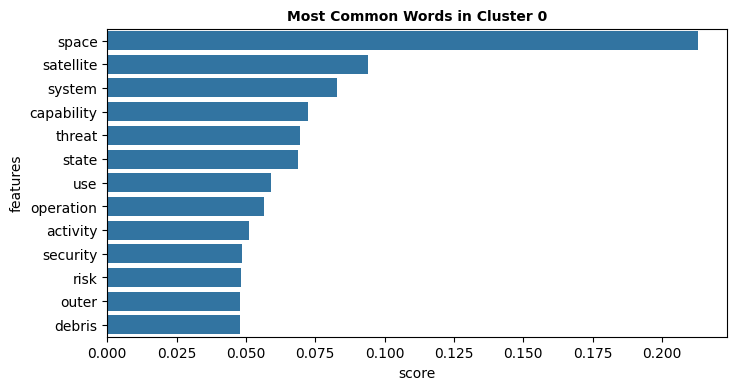

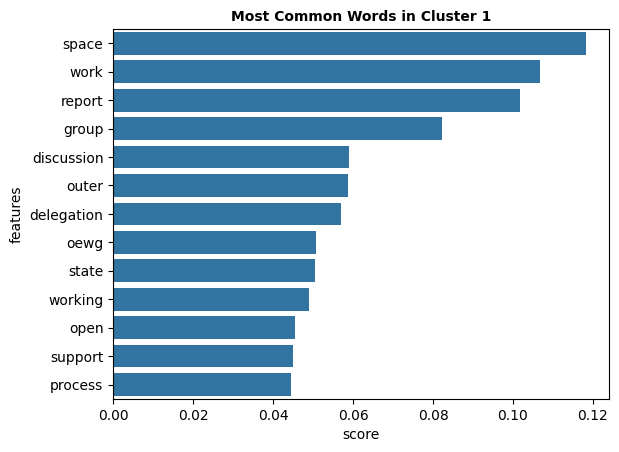

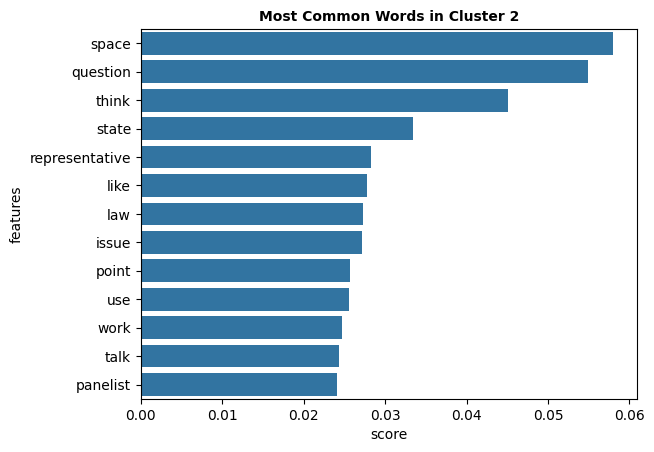

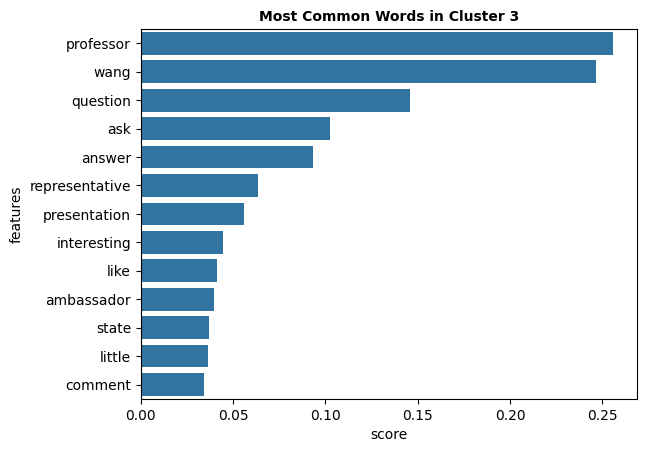

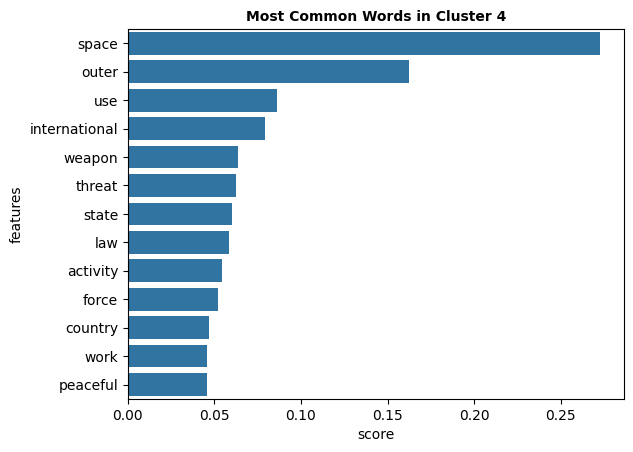

In [63]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [64]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

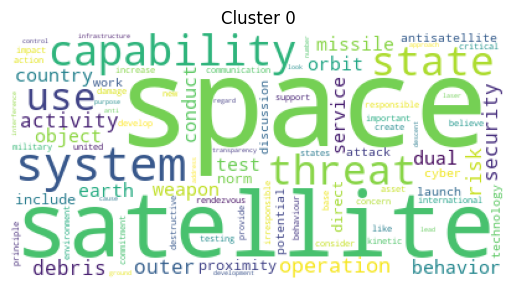

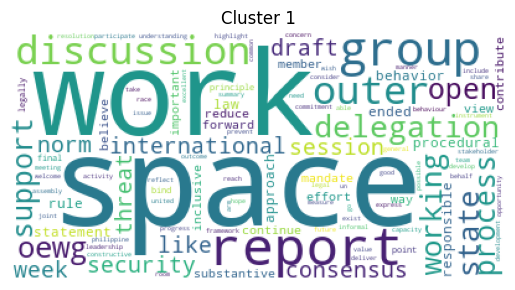

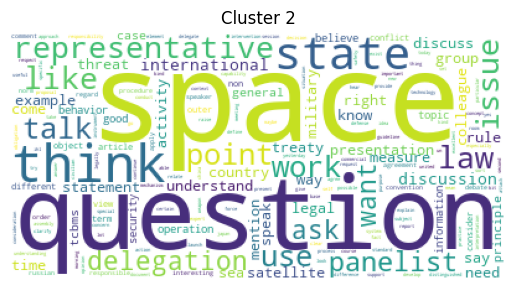

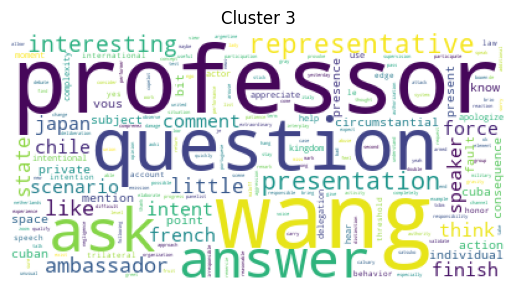

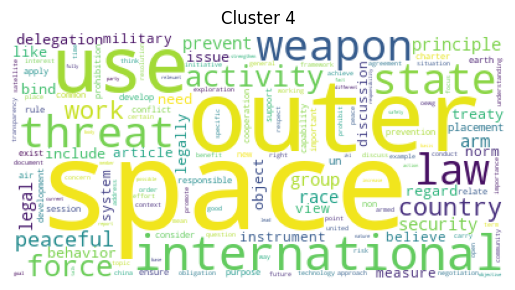

In [65]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [66]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
df_updated['Cluster'] = labels
df_updated.head()

Id  Session  Meeting Speaker  \
1  S1M12        1        1   Chile   
2  S1M13        1        1  Russia   
4  S1M15        1        1    Cuba   
5  S1M16        1        1  Geneva   
6  S1M17        1        1    Cuba   

                                                Text  Cluster  
1  Before going to the logistics and the backgrou...        1  
2  Thank you, Mr. President. I will now ask for t...        2  
4  Cuba representative, please. Thank you, Presid...        2  
5  Thank you, Mr. President. And once again, I we...        2  
6  I understand that it is necessary for the Cuba...        2

In [47]:
#drop the label column
#

/var/folders/5r/2zxjpss509zbfp38213y6wv00000gn/T/ipykernel_84515/794651026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_updated.drop(columns = ['label'], inplace = True)


Id  Session  Meeting      Speaker  \
1   S3M52        3        5       Russia   
3   S3M54        3        5  New Zealand   
5   S3M56        3        5        Italy   
7   S3M58        3        5        China   
9  S3M510        3        5       Canada   

                                                Text  Cluster  
1  Mr. Chairman. We would like to take the floor ...        1  
3  Thank you, Mr. Chair, when New Zealand conside...        1  
5  Thank you, Mr. Chair. As we said many times be...        1  
7  Thank you, Mr. Chairman. China believes that d...        1  
9  Thank you, Mr. Chair. Hopefully we can get a l...        4

In [67]:
# Print all unique values in the 'speaker' column
print(df_updated['Speaker'].unique())

['Chile' 'Russia' 'Cuba' 'Geneva' 'United Nation' 'Japan' 'France'
 'Russian' 'Mexico' 'Austria' 'United States' 'India' 'Portugal' 'Couplot'
 'Canada' 'Secretary' 'Hong' 'China' 'European Union' 'Turkey' 'French'
 'Germany' 'United Kingdom' 'Sri Lanka' 'President' 'Portuguese'
 'Netherlands' 'Italy' 'Argentine' 'Sri Lanks' 'United Arab' 'Switzerland'
 'Brazil' 'Polish' 'Iran' 'New Zealand' 'Israel' 'Indonesian' 'Chechen'
 'Australia' 'Finland' 'Venezuela' 'Algeria' 'Korea' 'United Nations'
 'Mississippi.' 'Mississippi' 'Askara' 'Askarta' 'Sweden' 'Spain'
 'Oskarot' 'Pakistan' 'Indonesia' 'Oskar' 'Philippines'
 'Secure World Foundation' 'Stockholm' 'South Africa' 'Martinez' 'Uruguay'
 'Mr. Clark' 'Unidir' 'Cambodia' 'Norway' 'The Republic of Korea'
 'The Secure World Foundation'
 'The Australian Center for Space Governance' 'Belgium' 'Egypt' 'Ireland'
 'Saudi Arabia' 'ICRC' 'Poland' 'The Observer Research Foundation'
 'The Hillasa Center Institute of Physics of the Czech Academy of Sci

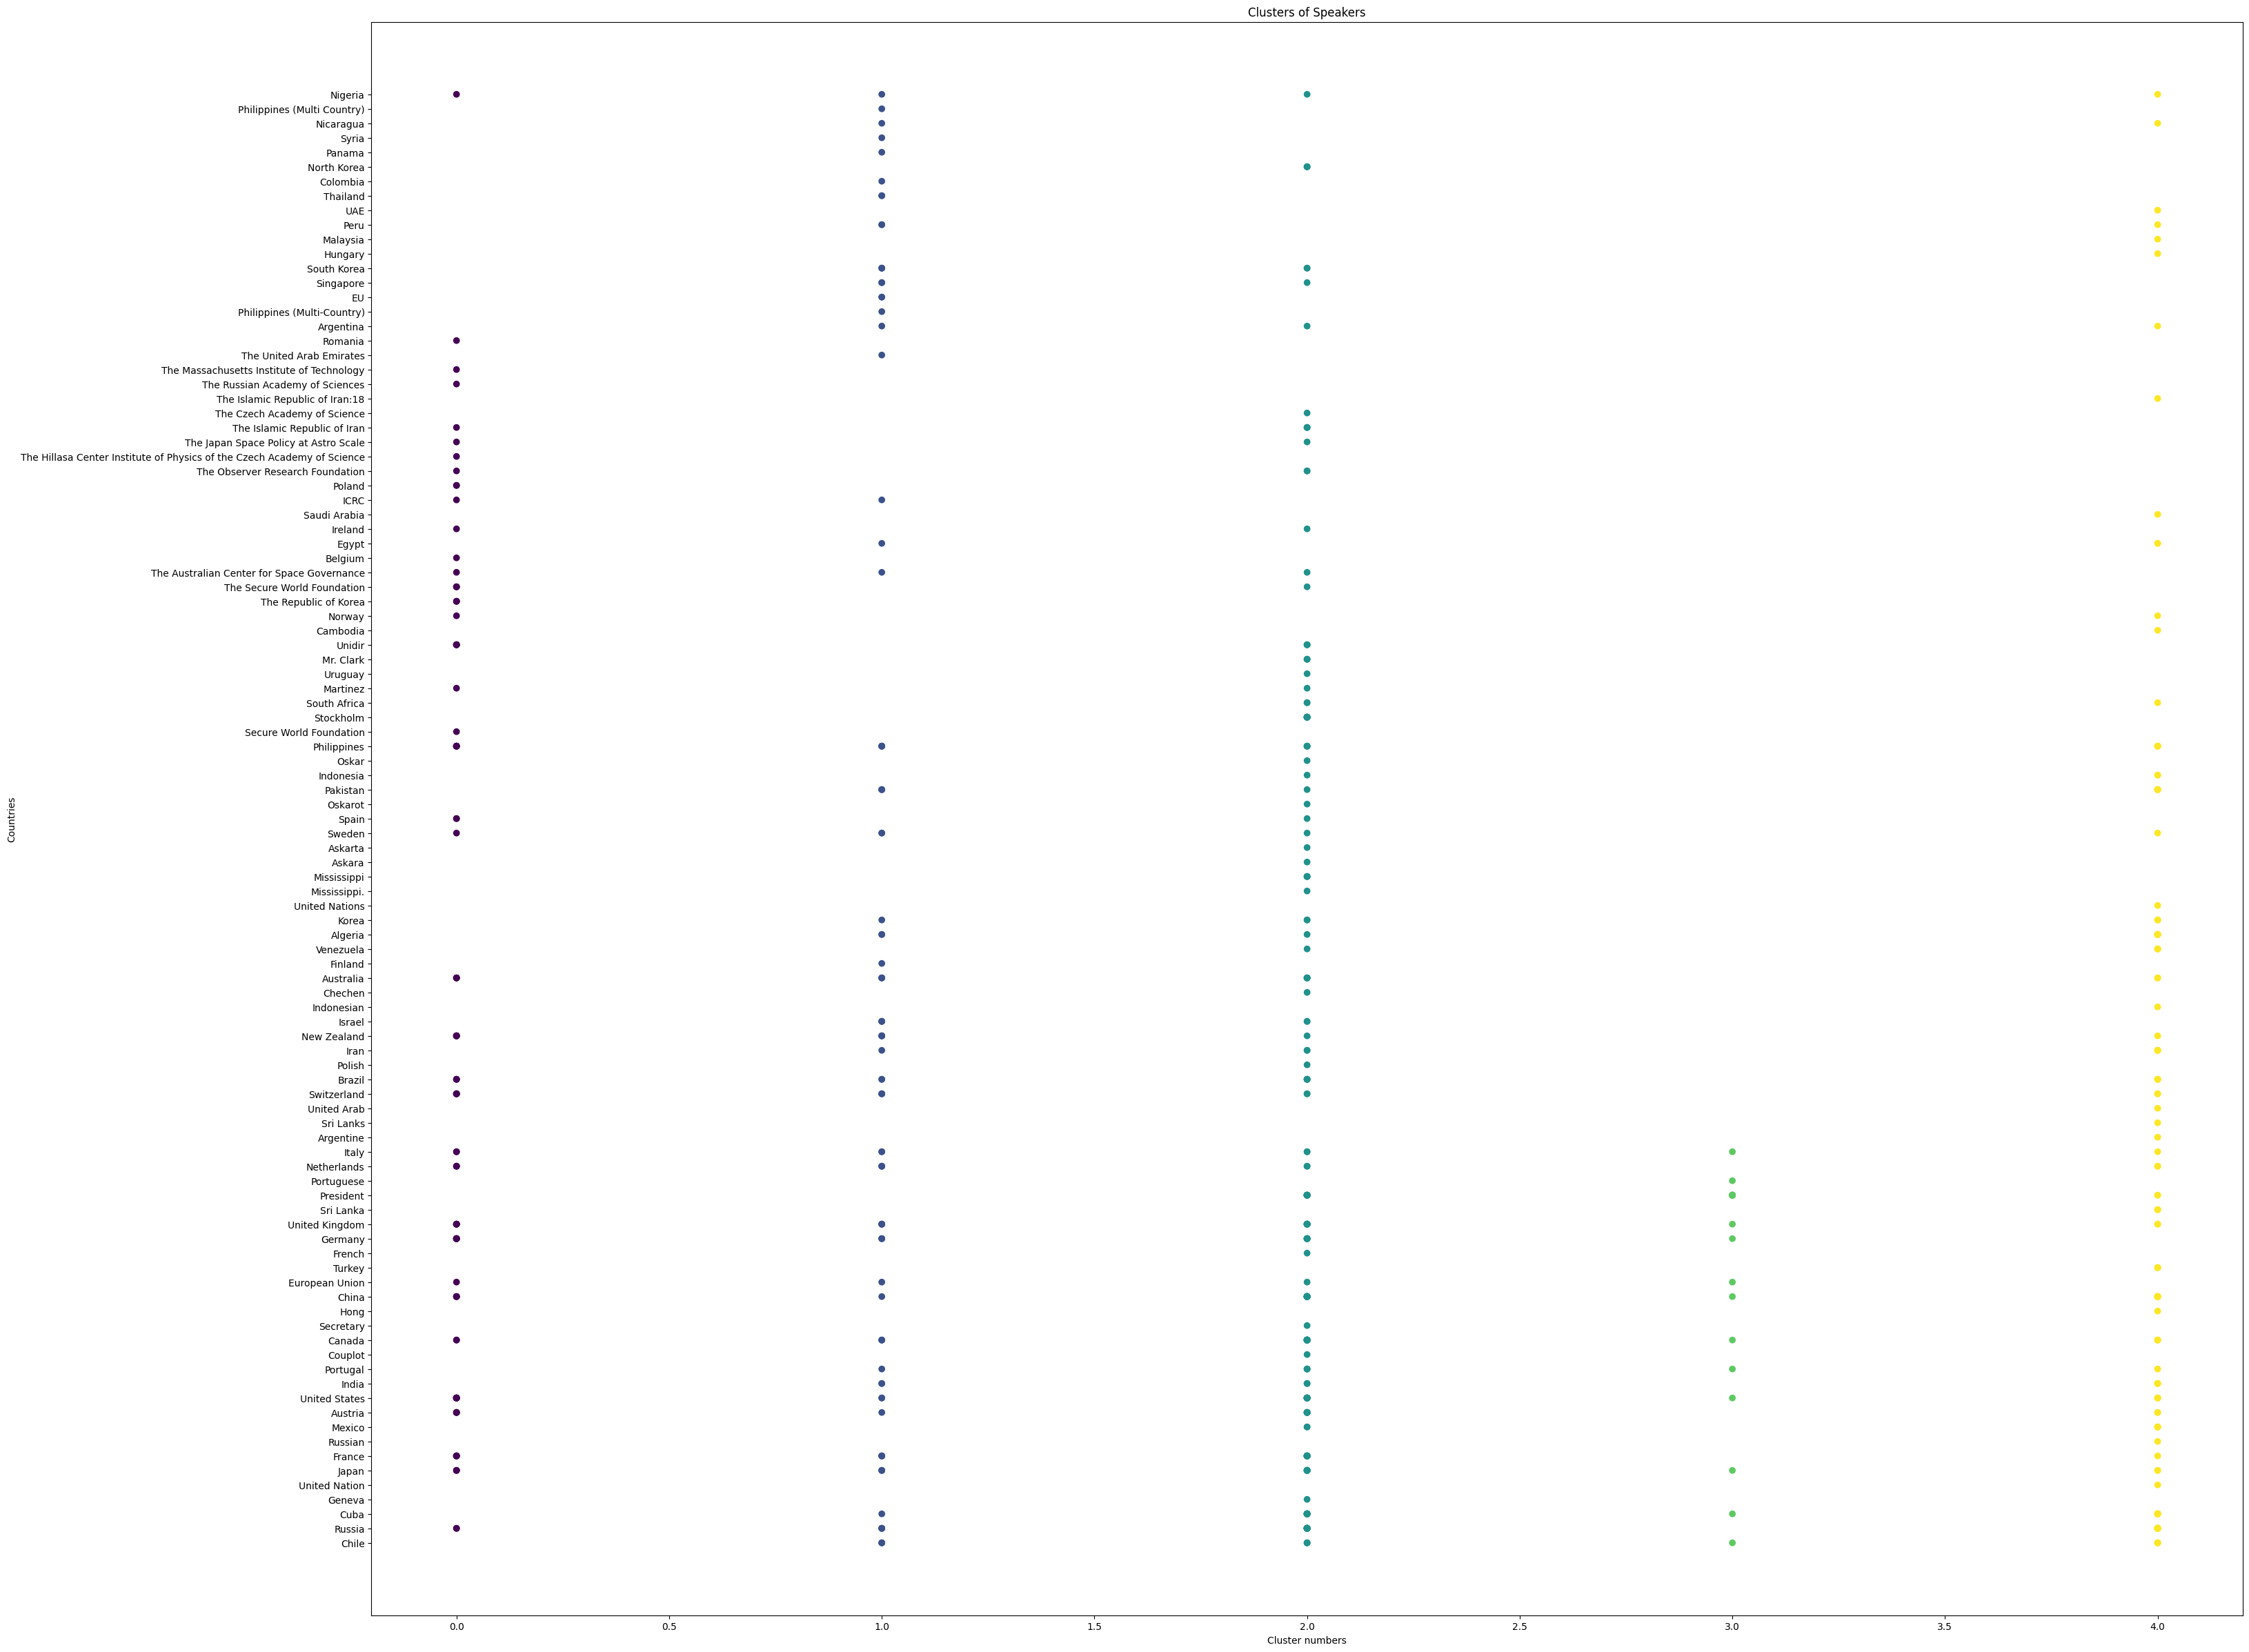

In [71]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(35, 30))
plt.scatter(df_updated['Cluster'], df_updated['Speaker'], c=df_updated['Cluster'], cmap='viridis')

# Add labels and title
plt.xlabel('Cluster numbers')
plt.ylabel('Countries')
plt.title('Clusters of Speakers')

# Show the plot
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


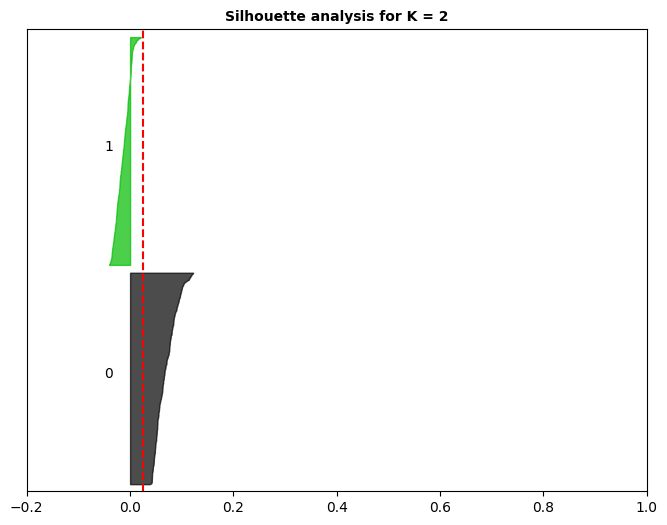

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


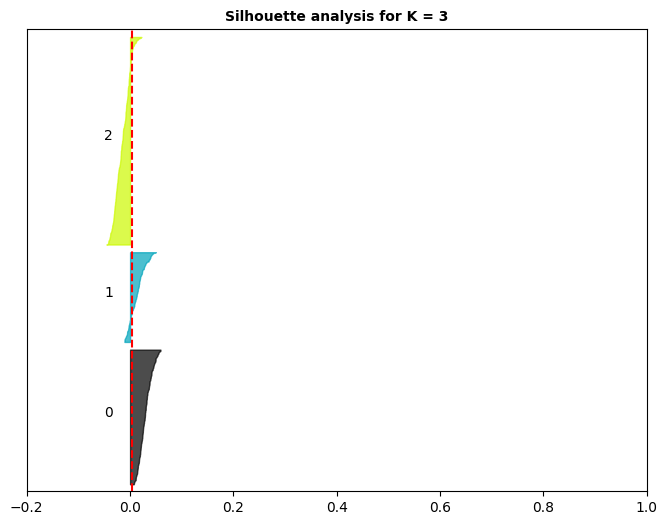

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


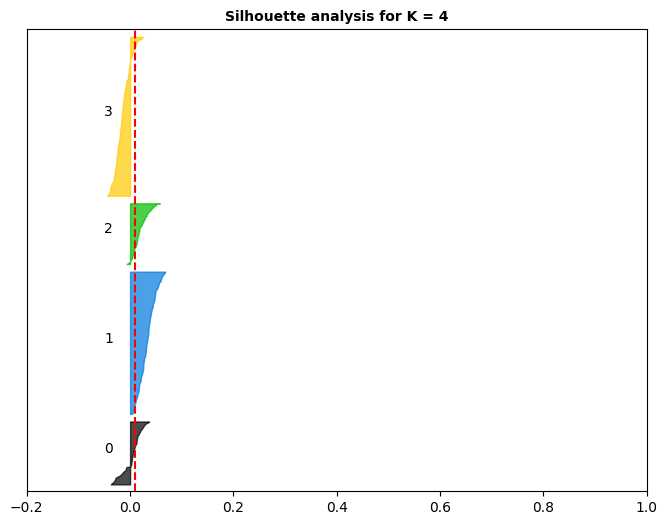

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


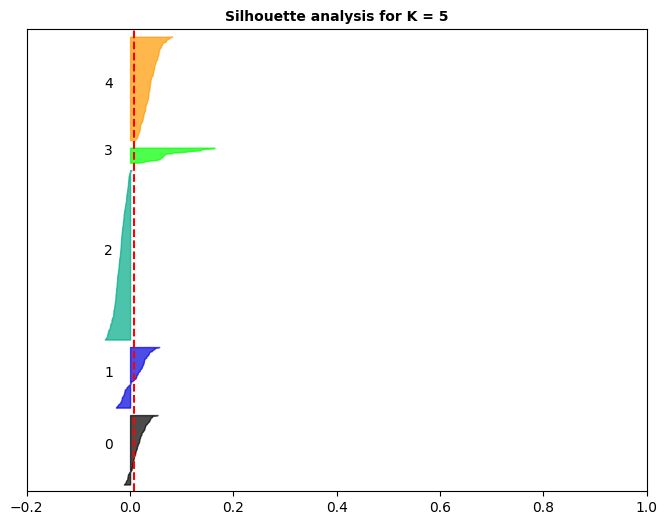

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


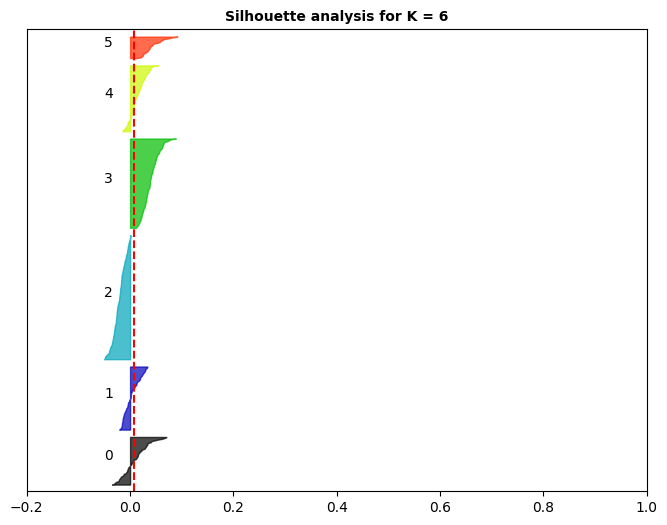

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


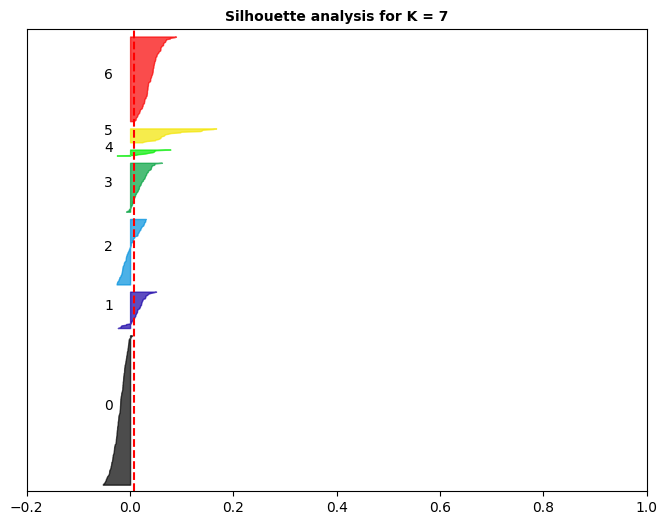

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


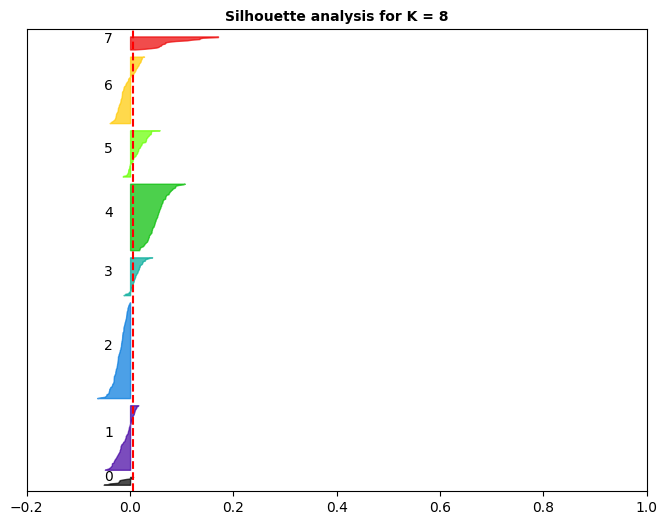

In [72]:
# Plotting Silhouette Analysis - For Evaluation
silhouette(kmeans_results, final_df, plot=True)

In [73]:
#save the df_updated into a csv file in the csv folder
df_updated.to_csv('Language_analysis/total_language_analysis.csv', index=False)
